# Упражнение 1
Этот элемент курса оценивается как 'Упражнение 1'  
вес: 1.0

Шел трамвай десятый номер…

А у нас трамвай номер 6, потому что такой трамвай проходит мимо главного корпуса университета ИТМО. Обычно при подходе к остановке у каждого трамвая фиксируется время. Но иногда датчик дает сбой, и время прохождения остановки не фиксируется. А данные с пропущенными значениями – это очень неудобно. Давайте попробуем восстановить пропущенное время прохождения остановок. Как это сделать? Определить пропорции прохождения каждой неопределенной остановки маршрута, усреднив время прохождения этой же остановки другими трамваями этого маршрута без пропусков. Конечно, если бы наш трамвай попал в пробку, или на его пути оказалась бы авария, то время на прохождение остановки могло бы сильно отличаться от среднестатистического – мы бы приняли его за выброс и удалили из рассмотрения. Но с нашими трамваями в тот день такие неприятности не случались.

Общее время прохода нескольких остановок тоже надо усреднить, определить пропорции – и пропущенные значения легко будут восстановлены.

С примером решения можете ознакомиться по [ссылке](./Пример_расчета__2_.pdf).

## Задание
Восстановить пропущенные значения [таблицы](./ITMOUniversity+DATAN+summer_2018+type@asset+block@1.2.csv) в формате ЧЧ:ММ:СС.
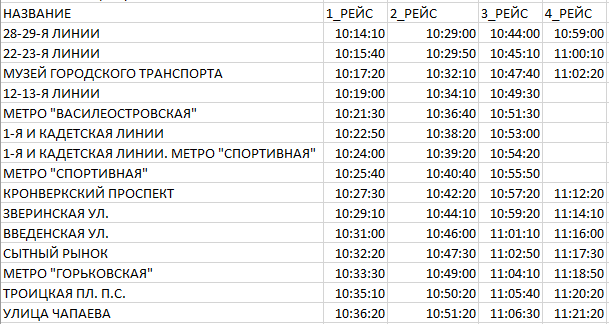

In [40]:
import numpy as np
import pandas as pd
import time

In [41]:
df = pd.read_csv('./ITMOUniversity+DATAN+summer_2018+type@asset+block@1.2.csv')
#print(df.info())
#print(df.columns)
df

,НАЗВАНИЕ,1_РЕЙС,2_РЕЙС,3_РЕЙС,4_РЕЙС
0,28-29-Я ЛИНИИ,10:14:10,10:29:00,10:44:00,10:59:00
1,22-23-Я ЛИНИИ,10:15:40,10:29:50,10:45:10,11:00:10
2,МУЗЕЙ ГОРОДСКОГО ТРАНСПОРТА,10:17:20,10:32:10,10:47:40,11:02:20
3,12-13-Я ЛИНИИ,10:19:00,10:34:10,10:49:30,NaN
4,"МЕТРО ""ВАСИЛЕОСТРОВСКАЯ""",10:21:30,10:36:40,10:51:30,NaN
5,1-Я И КАДЕТСКАЯ ЛИНИИ,10:22:50,10:38:20,10:53:00,NaN
6,"1-Я И КАДЕТСКАЯ ЛИНИИ. МЕТРО ""СПОРТИВНАЯ""",10:24:00,10:39:20,10:54:20,NaN
7,"МЕТРО ""СПОРТИВНАЯ""",10:25:40,10:40:40,10:55:50,NaN
8,КРОНВЕРКСКИЙ ПРОСПЕКТ,10:27:30,10:42:20,10:57:20,11:12:20
9,ЗВЕРИНСКАЯ УЛ.,10:29:10,10:44:10,10:59:20,11:14:10


In [42]:
# Преобразуем даты в формат Int64 для большего удобства в вычислениях (все время в нс, нам важна только разница в данном случае)
df['1_РЕЙС'] = pd.to_datetime(df['1_РЕЙС']).astype(np.int64)
df['2_РЕЙС'] = pd.to_datetime(df['2_РЕЙС']).astype(np.int64)
df['3_РЕЙС'] = pd.to_datetime(df['3_РЕЙС']).astype(np.int64)
df['4_РЕЙС'] = pd.to_datetime(df['4_РЕЙС']).astype(np.int64, errors='ignore')

# Отображаем только интересующий нас интервал
work_df = df.iloc[2:9,:]
work_df

,НАЗВАНИЕ,1_РЕЙС,2_РЕЙС,3_РЕЙС,4_РЕЙС
2,МУЗЕЙ ГОРОДСКОГО ТРАНСПОРТА,1631096240000000000,1631097130000000000,1631098060000000000,2021-09-08 11:02:20
3,12-13-Я ЛИНИИ,1631096340000000000,1631097250000000000,1631098170000000000,NaT
4,"МЕТРО ""ВАСИЛЕОСТРОВСКАЯ""",1631096490000000000,1631097400000000000,1631098290000000000,NaT
5,1-Я И КАДЕТСКАЯ ЛИНИИ,1631096570000000000,1631097500000000000,1631098380000000000,NaT
6,"1-Я И КАДЕТСКАЯ ЛИНИИ. МЕТРО ""СПОРТИВНАЯ""",1631096640000000000,1631097560000000000,1631098460000000000,NaT
7,"МЕТРО ""СПОРТИВНАЯ""",1631096740000000000,1631097640000000000,1631098550000000000,NaT
8,КРОНВЕРКСКИЙ ПРОСПЕКТ,1631096850000000000,1631097740000000000,1631098640000000000,2021-09-08 11:12:20


In [43]:
# Списки временных интервалов прохождения остановок для конкретного рейса
# т.е. сколько времени нужно, чтобы добраться от одной остановки до следующей
sub1 = work_df[1:]['1_РЕЙС'].values - work_df[0:-1]['1_РЕЙС'].values
sub2 = work_df[1:]['2_РЕЙС'].values - work_df[0:-1]['2_РЕЙС'].values
sub3 = work_df[1:]['3_РЕЙС'].values - work_df[0:-1]['3_РЕЙС'].values

# Список среднего времени прохождения остановки, основываясь на данных первых трех рейсов
mean_subs = ((sub1 + sub2 + sub3) / 3).astype(np.int64)

# Cуммарное cреднее время прохождения всех остановок
mean_time_from_first_to_last = mean_subs.sum()

print('Среднее время прохождения от первой до последней остановки')
print('В нс:', mean_time_from_first_to_last, '\t В формате времени:', pd.to_datetime(mean_time_from_first_to_last).time())

Среднее время прохождения от первой до последней остановки
В нс: 600000000000 	 В формате времени: 00:10:00


In [44]:
# Время начала интересующего диапазона
reys4_start = pd.to_datetime(work_df.loc[2,['4_РЕЙС']]).astype(np.int64).values[0]

# Время конца интересующего диапазона
reys4_end = pd.to_datetime(work_df.loc[8,['4_РЕЙС']]).astype(np.int64).values[0]

# Время прохождения остановок, про которые ничего не известно
reys4_duration = reys4_end - reys4_start

reys4_duration, mean_subs, mean_time_from_first_to_last

(600000000000,
 array([110000000000, 140000000000,  90000000000,  70000000000,
         90000000000, 100000000000], dtype=int64),
 600000000000)

In [51]:
# Рассчитанные значения времени прохождения каждой из интересующих остановок для 4 рейса
reys4_segments = (reys4_duration * (mean_subs / mean_time_from_first_to_last)).astype(np.int64)
reys4_segments

array([109999999999, 140000000000,  90000000000,  70000000000,
        90000000000, 100000000000], dtype=int64)

In [54]:
# Создаем список, который будет содержать время прибытия в интересующую остановку
reys4_stops = [reys4_start]

for seg in reys4_segments:
    reys4_stops.append(reys4_stops[-1] + seg)

# Убираем из итогового списка reys4_start и инвертируем его
reys4_stops = reys4_stops[1:-1]
print('reys4_stops: ', reys4_stops)

# Список со временем прибытия в интересующие остановки для 4 рейса, округляем до секунд
stops = pd.to_datetime(reys4_stops).round('1s')

# print(stops.shape, work_df.loc[3:7,'4_РЕЙС'].shape)
work_df.loc[3:7,'4_РЕЙС'] = stops.time
work_df

reys4_stops:  [1631099049999999999, 1631099189999999999, 1631099279999999999, 1631099349999999999, 1631099439999999999]


,НАЗВАНИЕ,1_РЕЙС,2_РЕЙС,3_РЕЙС,4_РЕЙС
2,МУЗЕЙ ГОРОДСКОГО ТРАНСПОРТА,1631096240000000000,1631097130000000000,1631098060000000000,2021-09-08 11:02:20
3,12-13-Я ЛИНИИ,1631096340000000000,1631097250000000000,1631098170000000000,11:04:10
4,"МЕТРО ""ВАСИЛЕОСТРОВСКАЯ""",1631096490000000000,1631097400000000000,1631098290000000000,11:06:30
5,1-Я И КАДЕТСКАЯ ЛИНИИ,1631096570000000000,1631097500000000000,1631098380000000000,11:08:00
6,"1-Я И КАДЕТСКАЯ ЛИНИИ. МЕТРО ""СПОРТИВНАЯ""",1631096640000000000,1631097560000000000,1631098460000000000,11:09:10
7,"МЕТРО ""СПОРТИВНАЯ""",1631096740000000000,1631097640000000000,1631098550000000000,11:10:40
8,КРОНВЕРКСКИЙ ПРОСПЕКТ,1631096850000000000,1631097740000000000,1631098640000000000,2021-09-08 11:12:20
